In [1]:
import spacy
import os
import json
import pandas as pd 
import re
from datetime import datetime
import numpy as np

model_path = os.path.join('..', 'models', 'tpb_labeller', 'model-best')

raw_n = 'tpb_tweets_filtered_20220328.json'
in_n = 'tpb_contextcat_20220531.jsonl'
out_n_xls = 'tpb_context-tweets_labelled-predicted.xlsx'
out_n_csv = 'tpb_context-tweets_labelled-predicted.csv'

# columns names for labels
old_label_cols = ['The backdrop of physical stuckness',
                  'Existing precarity and vulnerabilities',
                  'Context of blocked and derailed mobilities',
                  'New mobilities and migratory routes',
                  'Other'
                 ]
new_label_cols = ['The backdrop of physical stuckness',
                  'Existing precarity and vulnerabilities',
                  'Context of blocked and derailed mobilities',
                  'Mobility along new and old routes'
                 ]
label_rename_map = dict(zip(old_label_cols, new_label_cols))

data_p = os.path.join('..', 'data')

data_raw_p = os.path.join(data_p, raw_n)
data_in_p = os.path.join(data_p, in_n)
data_out_p_xls = os.path.join(data_p, out_n_xls)
data_out_p_csv = os.path.join(data_p, out_n_csv)

nlp = spacy.load(model_path)

In [2]:
# loading data
with open(data_raw_p, 'r') as f:
    data = json.load(f)

df_raw = pd.DataFrame.from_records(data)

with open(data_in_p, 'r') as f:
    data = [json.loads(line) for line in f]

df_in = pd.DataFrame.from_records(data)

# recreate id from link
id_regex = re.compile(r'(?<=/)(\d{15,20})$')
df_raw['id'] = df_raw['tweet_link'].str.extract(id_regex)
df_in['id'] = df_in['tweet_link'].str.extract(id_regex)

# tidy - one row per label
df_raw = df_raw.drop_duplicates('id')
df_in = df_in.explode('accept').reset_index(drop = True)

In [3]:
# indicator for part of training of model or not (trained on april 29th 2022 - NOTE: Unknown whether part of train or test set)

filter_timestamp = datetime.timestamp(datetime.fromisoformat('2022-04-29T23:59:59'))

df_in['training'] = 0
df_in.loc[df_in['_timestamp'] < filter_timestamp, 'training'] = 1 

In [4]:
# Function for prediction using model
def predict_cat(text):
    doc = nlp(text)
    return_predict = {}
    
    predicted_cats = doc.cats
    
    max_cat_score = max(predicted_cats.values())
    
    return_predict['predict_cat'] = max(predicted_cats, key = predicted_cats.get)
    return_predict['predict_score'] = max_cat_score
    
    return(return_predict)

In [5]:
# Predict for tweets not part of training
df_predicted = pd.json_normalize(df_in['text'].apply(predict_cat))
df_in = pd.merge(df_in, df_predicted, how = 'left', left_index = True, right_index = True)

df_in.loc[df_in['answer'] == 'ignore', ['predict_cat', 'predict_score']] = np.nan
df_in.loc[df_in['training'] == 1, ['predict_cat', 'predict_score']] = np.nan

In [6]:
# Change column names
df_in['accept'] = df_in['accept'].replace(label_rename_map)
df_in['predict_cat'] = df_in['predict_cat'].replace(label_rename_map)

# Filter ignored
df_in_merge = df_in.loc[df_in['answer'] != 'ignore', ['id', 'accept', 'training', 'predict_cat', 'predict_score']]

# Merge
df_merged = pd.merge(df_in_merge, df_raw, how = 'inner', on = 'id')


In [7]:
# reorder columns - tidy
columns_neworder = ['created_at', 'name', 'username', 'text', 'tweet_link', 'training', 'accept', 'predict_cat', 'predict_score', 'id', 'hashtags', 'urls', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'referenced_type', 'referenced_id']
df_out = df_merged.loc[:, columns_neworder].rename(columns = {'accept': 'label',
                                                             'predict_cat': 'predicted label',
                                                             'predict_score': 'prediction precision',
                                                             'training': 'used for model training'})

# id as string
df_out['id'] = df_out['id'].astype('str')

# training as bool
df_out['used for model training'] = df_out['used for model training'].astype(bool)

# convert to datetime
df_out['created_at'] = pd.to_datetime(df_out['created_at']).dt.tz_localize(None) # removing timezone

# sort by datetime (old to new)
df_out = df_out.sort_values('created_at')

In [10]:
# export
df_out.to_excel(data_out_p_xls, index = False)
df_out.to_csv(data_out_p_csv, index = False)

In [8]:
# visualize
df_out['correct'] = df_out['label'] == df_out['predicted label']

cat_order = ['Existing precarity and vulnerabilities',
             'Mobility along new and old routes',
             'Context of blocked and derailed mobilities',
             'The backdrop of physical stuckness',
             'Other'
            ]

label_cat = pd.Categorical(df_out['label'], categories=cat_order)

df_out = df_out.assign(label_cat = label_cat)

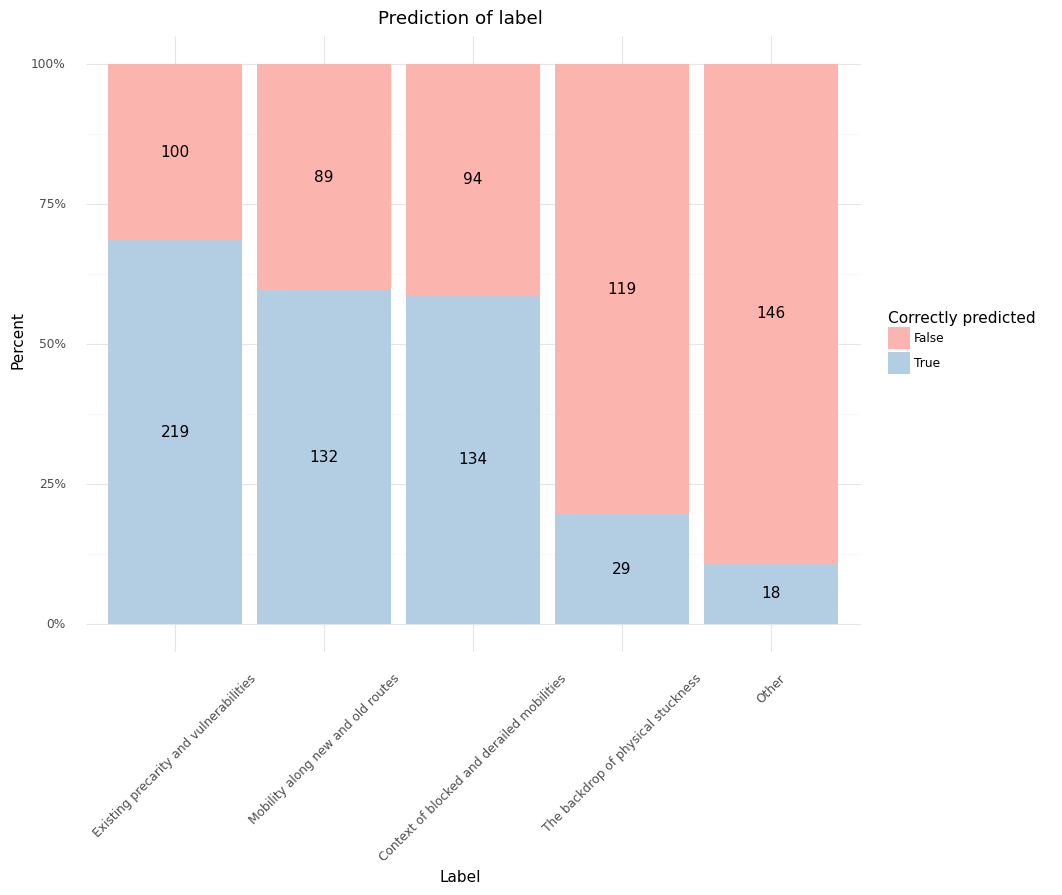

<ggplot: (8779438195990)>

In [49]:
import plotnine
from plotnine import ggplot, geom_point, geom_bar, aes, stat_smooth, facet_wrap, theme, element_text, labs, scale_y_continuous, labels, scale_fill_brewer, geom_smooth, theme_classic, theme_minimal, geom_text, position_stack

plotnine.options.figure_size = (10,8)

df_viz = df_out.loc[df_out['used for model training'] == False, :]

counts = df_viz.groupby(['label_cat', 'correct']).size()
label_groups = df_viz.groupby(['label_cat']).size()
pct = counts / label_groups
label_count = pd.concat([counts, pct], axis = 1).reset_index().rename(columns = {0:'count', 1:'pct'})

(ggplot(label_count, aes(x = 'label_cat', y = 'pct', fill='factor(correct)'))
 + geom_bar(stat = 'identity', position = 'fill')
 + geom_text(aes(label = 'count'), position = position_stack(vjust=0.5))
 + labs(x = "Label", y = "Percent", fill = "Correctly predicted", title = "Prediction of label")
 + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l])
 + scale_fill_brewer(type = 'qual', palette = 4)
 + theme_minimal()
 + theme(axis_text_x = element_text(angle = 45)))

/work/tmenv/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


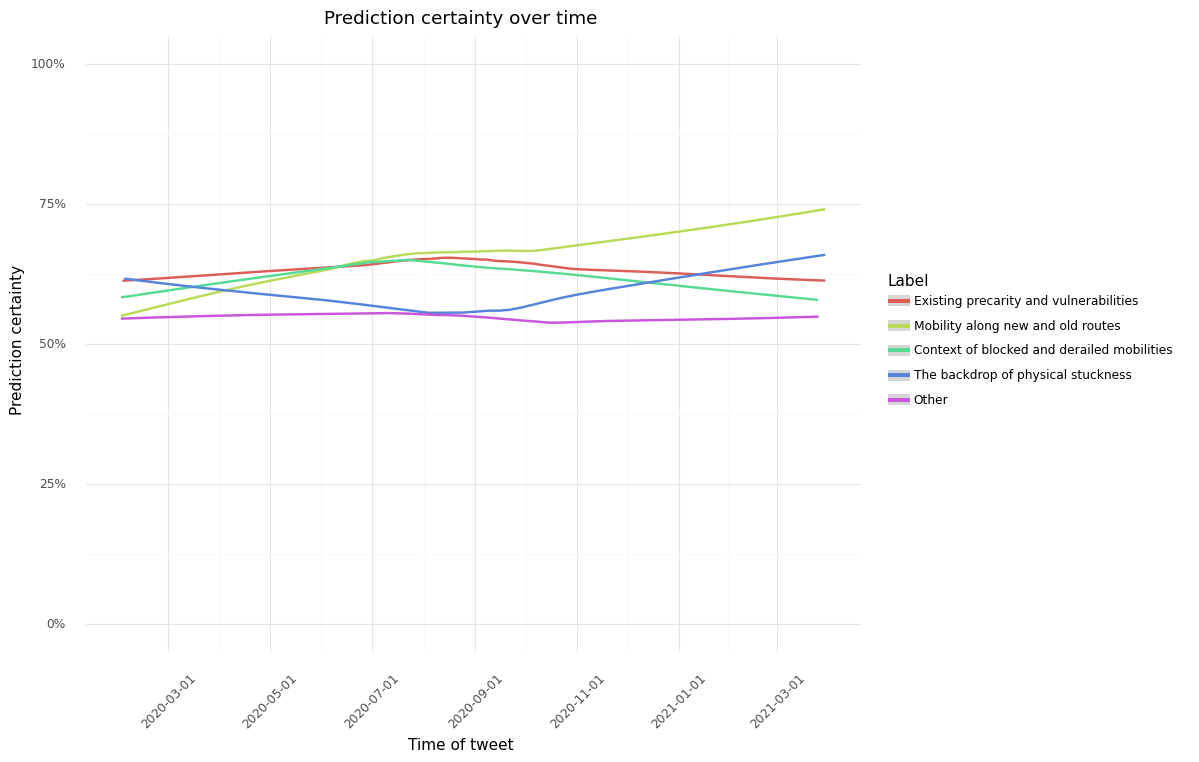

<ggplot: (8778968004018)>

In [54]:
from plotnine import theme_minimal

(ggplot(df_viz, aes(x = 'created_at', y = 'prediction precision', colour='factor(label_cat)'))
 + geom_smooth()
 + labs(x = "Time of tweet", y = "Prediction certainty", colour = "Label", title = "Prediction certainty over time")
 + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l], limits = (0,1))
 + theme_minimal()
 + theme(axis_text_x = element_text(angle = 45))
)